In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import keras

In [ ]:
# load the whole dataset, for data info
all_ds   = tfds.load("eurosat", with_info=True)
# load training, testing & validation sets, splitting by 60%, 20% and 20% respectively
train_ds = tfds.load("eurosat", split="train[:60%]")
test_ds  = tfds.load("eurosat", split="train[60%:80%]")
valid_ds = tfds.load("eurosat", split="train[80%:]")

In [ ]:
class_names = all_ds[1].features["label"].names
# total number of classes (10)
num_classes = len(class_names)
num_examples = all_ds[1].splits["train"].num_examples

In [ ]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [ ]:
batch_size = 64

# preprocess training & validation sets
train_ds = prepare_for_training(train_ds, batch_size=batch_size)
valid_ds = prepare_for_training(valid_ds, batch_size=batch_size)

In [ ]:
# validating shapes
for el in valid_ds.take(1):
  print(el[0].shape, el[1].shape)
for el in train_ds.take(1):
  print(el[0].shape, el[1].shape)

(64, 64, 64, 3) (64, 10)
(64, 64, 64, 3) (64, 10)


In [ ]:
batch = next(iter(train_ds))

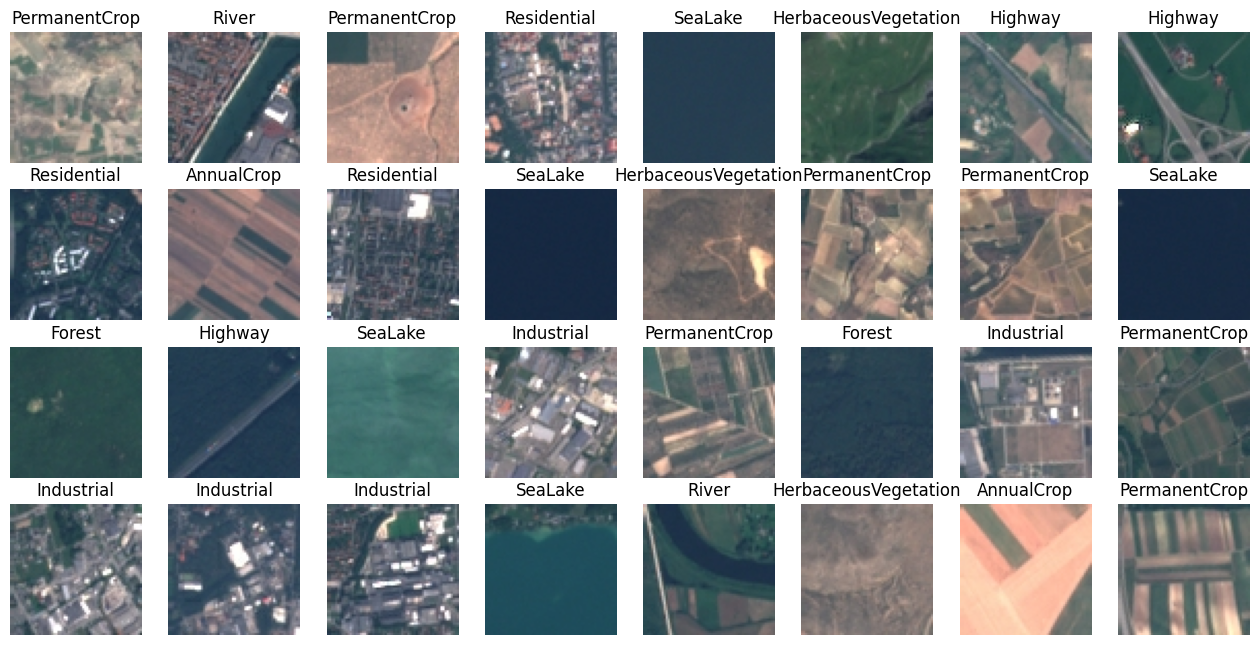

In [ ]:
def show_batch(batch):
  plt.figure(figsize=(16, 16))
  for n in range(min(32, batch_size)):
      ax = plt.subplot(batch_size//8, 8, n + 1)
      # show the image
      plt.imshow(batch[0][n])
      # and put the corresponding label as title upper to the image
      plt.title(class_names[tf.argmax(batch[1][n].numpy())])
      plt.axis('off')
      plt.savefig("sample-images.png")

# showing a batch of images along with labels
show_batch(batch)

In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
def get_model(input_shape):
    model = Sequential([
        Conv2D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, kernel_size=3,activation='relu',padding='same',),
        BatchNormalization(),
        MaxPooling2D(pool_size=2,),
        BatchNormalization(),
        Conv2D(16, kernel_size=3,activation='relu',padding='same',),
        BatchNormalization(),
        Conv2D(16, kernel_size=3,activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Flatten(name='flatten'),
        Dense(32,activation='relu',),
        BatchNormalization(),
        Dense(10,activation='softmax',)
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model


In [ ]:
n_training_steps   = int(num_examples * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(num_examples * 0.2) // batch_size

In [ ]:
model = get_model([64, 64, 3])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_ds, validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1, epochs=20,
)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.5996 - loss: 1.1887 - val_accuracy: 0.6324 - val_loss: 1.0577
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.7988 - loss: 0.5886 - val_accuracy: 0.8261 - val_loss: 0.5212
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.8568 - loss: 0.4376 - val_accuracy: 0.7788 - val_loss: 0.6385
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 252s 998ms/step - accuracy: 0.8884 - loss: 0.3428 - val_accuracy: 0.8093 - val_loss: 0.5860
Epoch 5/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.9154 - loss: 0.2580 - val_accuracy: 0.7723 - val_loss: 0.6985
Epoch 6/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9349 - loss: 0.2000 - val_accuracy: 0.8302 - val_loss: 0.5260
Epoch 7/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.9536 - loss: 0.1484 - val_accuracy: 0.8423 - val_loss: 0.4912
Epoch 8/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9538 - loss: 0.1379 - val_a

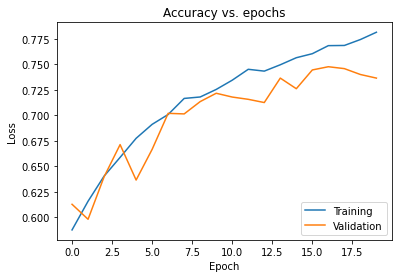

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

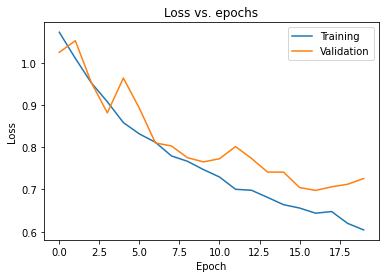

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
n_testing_steps = int(all_ds[1].splits["train"].num_examples * 0.2)

In [ ]:
# get all testing images as NumPy array
images = np.array([ d["image"] for d in test_ds.take(n_testing_steps) ])
print("images.shape:", images.shape)

images.shape: (5400, 64, 64, 3)


In [ ]:
# get all testing labels as NumPy array
labels = np.array([ d["label"] for d in test_ds.take(n_testing_steps) ])
print("labels.shape:", labels.shape)

labels.shape: (5400,)


In [ ]:
# feed the images to get predictions
predictions = model.predict(images)
# perform argmax to get class index
predictions = np.argmax(predictions, axis=1)
print("predictions.shape:", predictions.shape)

predictions.shape: (5400,)


In [ ]:
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, predictions)
print("Accuracy:", accuracy.result().numpy())

Accuracy: 0.72333336


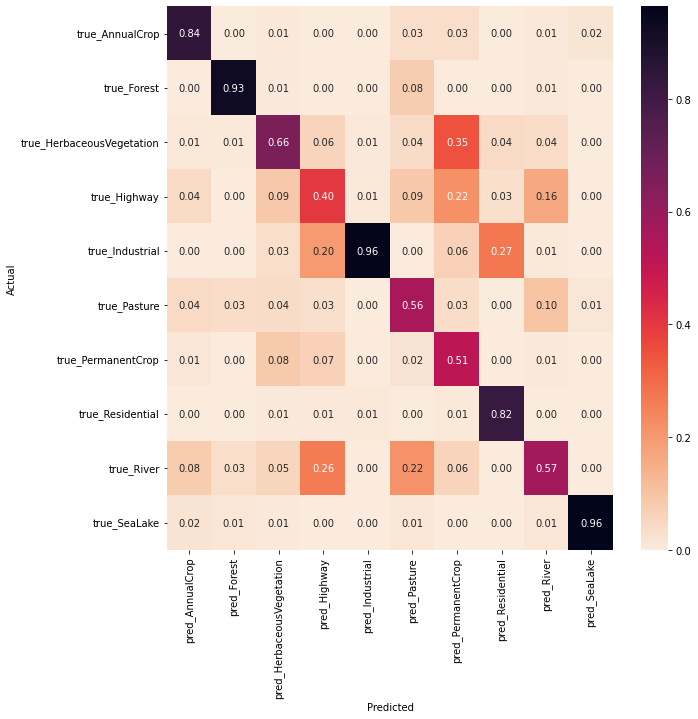

In [ ]:
# compute the confusion matrix
cmn = tf.math.confusion_matrix(labels, predictions).numpy()
# normalize the matrix to be in percentages
cmn = cmn.astype('float') / cmn.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f',
            xticklabels=[f"pred_{c}" for c in class_names],
            yticklabels=[f"true_{c}" for c in class_names],
            # cmap="Blues"
            cmap="rocket_r"
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")

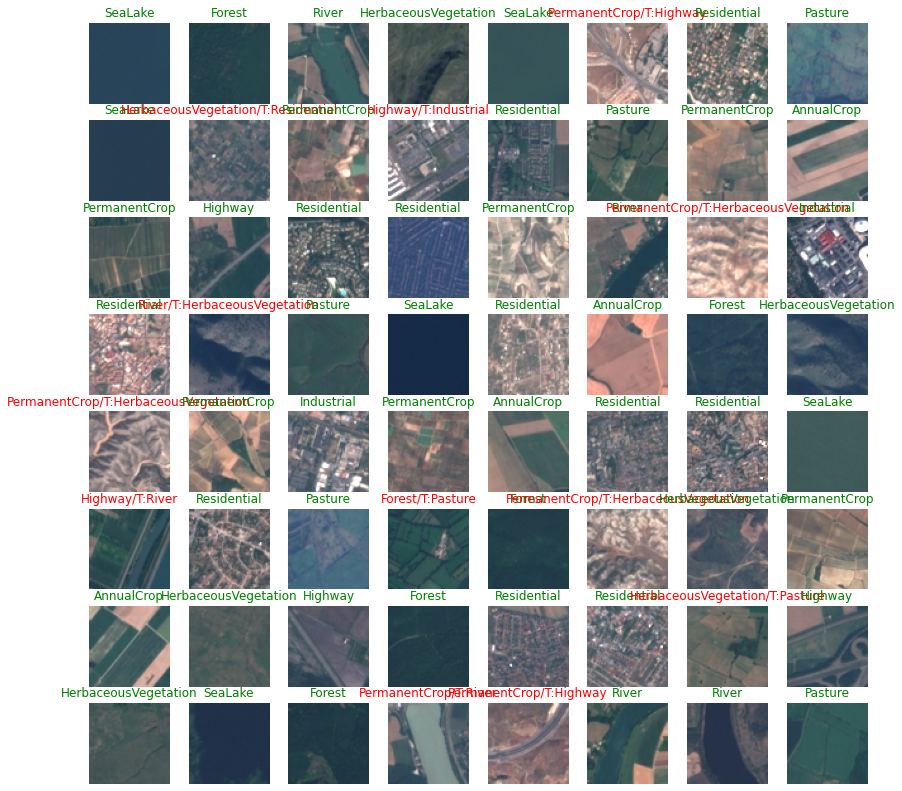

In [ ]:
def show_predicted_samples():
  plt.figure(figsize=(14, 14))
  for n in range(64):
      ax = plt.subplot(8, 8, n + 1)
      # show the image
      plt.imshow(images[n])
      # and put the corresponding label as title upper to the image
      if predictions[n] == labels[n]:
        # correct prediction
        ax.set_title(class_names[predictions[n]], color="green")
      else:
        # wrong prediction
        ax.set_title(f"{class_names[predictions[n]]}/T:{class_names[labels[n]]}", color="red")
      plt.axis('off')
      plt.savefig("predicted-sample-images.png")

# showing a batch of images along with predictions labels
show_predicted_samples()